### A notebook to support academic question exploration and literature search / what do you do when you search the literature?

0. Define a research question e.g Is occupational **asbestos exposure** an underecognised **cause** of IPF? 
1. Consider the different possible ways of answering the question (methods). Different study designs and ways of measuring asbestos exposure e.g Epidemiological, observational, cross-sectional, cohort, case-control, post-mortem and explant studies, ecological, toxicology, animal models, molecular disease models, exposure assessment, occupational hygeinst measurements, minerologic analysis (tissue, BAL etc)
2. Generate search terms e.g "IPF", "case-control", "occupational", "asbestos" (? && mesh terms)
3. Carry out search using search terms and e.g pubmed, google scholar, scopus, biorxiv, web of science, clinicaltrials.gov, ?google books
4. Search results == Candidate Papers
5. Extract title | journal | author | location | year | abstract | key words | full text && save result (as .bib) (prob want to export to jabref)
6. Review Candidate Papers to identify Relevant Papers 
7. Use Relevant Papers to identify more Candidate papers. Search also by author, cited by, cite, [triangle closing](https://en.wikipedia.org/wiki/Triadic_closure) e.g https://github.com/hinnefe2/bibcheck.py and other means (?tensorflow/scikit-learn,nltk)
8. Use the Relevant Papers collected for whatever it is they are relevant for (usually to help compose a written document in which they are cited)
9. ?django app times

meta: github/stack exchange etc to check out other peoples search strategies. this is likely to be formulated as a machine learning problem somewhere.

#### interesting related I found includes: https://www.projectcredo.com/, http://citationexplorer.hoppmann.me/, lict from a previous nhshackday, https://github.com/jvoytek/pubmedbrain/blob/f5170a2e3540e0c2aa665559c86048dfb1583f16/documents/Voytek-brainSCANrPreprint.pdf, https://github.com/graeham/hackathon/blob/master/paperGraph.py

### search github for relevant stuff with the following 'webbit' 
> https://github.com/search?l=Python&q=http%3A%2F%2Feutils.ncbi.nlm.nih.gov%2Fentrez%2Feutils%2Fesearch.fcgi++stars%3A%3E5&ref=advsearch&type=Code&utf8=%E2%9C%93

gists and interwebs inc stackoverflow also helpful

tempting to dive into django a la https://github.com/afouchet/OpenReview but probably not essential and now is not optimal timing

https://github.com/gui11aume looks well documented, poss useful template
https://github.com/swcarpentry/2013-08-23-harvard/blob/b2097bc20833e0a58b2e73eecd1227d61bd5a00a/lessons/misc-biopython/eutils.md looks like nice intro to biopython utils and https://gist.github.com/bonzanini/5a4c39e4c02502a8451d, https://gist.github.com/ehazlett/1104507, https://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 (for use of icite), https://gist.github.com/mcfrank/c1ec74df1427278cbe53, http://stackoverflow.com/questions/17409107/obtaining-data-from-pubmed-using-python, https://github.com/bwallace/abstrackr-web/tree/master/abstrackr, http://www.billconnelly.net/?p=44

### let's tackle pubmed first

In [1]:
"""
Notebook to support academic question exploration and literature search.

Thanks to https://marcobonzanini.wordpress.com/2015/01/12/searching-pubmed-with-python/ and 
http://www.fredtrotter.com/2014/11/14/hacking-on-the-pubmed-api/ and vtrubets
https://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 

Pubmed advanced search is helpful for designing search/experimenting 
https://www.ncbi.nlm.nih.gov/pubmed/advanced

Docs for NCBI esearch:
https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch
https://www.nlm.nih.gov/bsd/mms/medlineelements.html
"""


'\nNotebook to support academic question exploration and literature search.\n\nThanks to https://marcobonzanini.wordpress.com/2015/01/12/searching-pubmed-with-python/ and \nhttp://www.fredtrotter.com/2014/11/14/hacking-on-the-pubmed-api/\n\nPubmed advanced search is helpful for designing search/experimenting https://www.ncbi.nlm.nih.gov/pubmed/advanced\n\nDocs for NCBI esearch:\nhttps://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch\nhttps://www.nlm.nih.gov/bsd/mms/medlineelements.html\n'

In [2]:
from Bio import Entrez
from Bio import Medline
from tqdm import tqdm
import json
import requests
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_chunked_pmids(term, chunksize=50):
    """
    Return a list of Pubmed ids from pubmed search in chunks
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    count_handle = Entrez.esearch(db="pubmed",
                                  term=term,
                                  retmode="xml",
                                  rettype="count")
    count_results = Entrez.read(count_handle)
    count = int(count_results["Count"])

    retmax_requests = list(range(chunksize, count, chunksize))
    retmax_requests.append(count - retmax_requests[len(retmax_requests) - 1])

    for i, retmax in enumerate(retmax_requests):
        pmid_handle = Entrez.esearch(db="pubmed",
                                     term=term,
                                     sort="relevance",
                                     retmode="xml",
                                     usehistory='y',
                                     retstart=retmax,
                                     retmax=chunksize)
        results = Entrez.read(pmid_handle)
        yield results["IdList"]

In [4]:
def get_pubmed_summaries(pubmed_id):
    """
    Use the Pubmed API to return the summary of a pubmed article
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    pubmed_id = ', '.join(map(str, pubmed_id))
    handle = Entrez.esummary(db='pubmed', 
                             id=pubmed_id, 
                             retmode='json', 
                             rettype='abstract')
    return json.loads(handle.read())['result']
  

In [5]:
def get_pubmed_keywords(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the key words of a pubmed article.
    Return {pmid:[list of keywords]}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    kw = []
    keywords = {}
    for record in records:
        pmid = record.get('PMID','?')
        mh = record.get('MH','?')
        for w in mh: 
            if w not in kw:
                kw.append(w)
        kw.sort()
        keywords[pmid] = kw
    return keywords

In [6]:
def get_pubmed_abstracts(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the abstract of a pubmed article.
    Return {pmid:abstract}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    abstracts = {}
    for record in records:
        pmid = record.get('PMID','?')
        ab = record.get('AB','?')
        abstracts[pmid] = ab
    return abstracts

In [7]:
def get_pubmed_pubtypes(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the abstract of a pubmed article.
    Return {pmid:pubtype}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    pubtypes = {}
    for record in records:
        pmid = record.get('PMID','?')
        pt = record.get('PT','?')
        pubtypes[pmid] = pt
    return pubtypes

In [37]:
def get_citation_information(pubmed_id):
    """
    Use the special citation api to return relative citation ratios
    """
    pubmed_id = ','.join(pubmed_id)
    citation_search = 'https://icite.od.nih.gov/api/pubs?pmids={0}'.format(pubmed_id)
    response = requests.get(citation_search).content
    str_response = response.decode('utf-8')
    
    try:
        data = json.loads(str_response)['data']
    except KeyError:
        data = False
         
    citations = {}
    
    if data:
        for record in data:
            pmid = record.get('pmid')
            rcr = record.get('relative_citation_ratio')
            citations[pmid] = rcr
            
    return citations
        

In [29]:
def lit_search(term):
    """
    Search pubmed for a term and collect information about the results
    """
    pmid_blocks = get_chunked_pmids(term, chunksize=200)
    summaries = []
    pubtypes = []
    abstracts = []
    keywords = []
    rcrs = []
    litsearch_results = [summaries, pubtypes, abstracts, keywords, rcrs]
    for i, block in enumerate(pmid_blocks):
        summaries.append(get_pubmed_summaries(block))
        pubtypes.append(get_pubmed_pubtypes(block))
        abstracts.append(get_pubmed_abstracts(block))
        keywords.append(get_pubmed_keywords(block))
        rcrs.append(get_citation_information(block))
        print("Processed block {0}".format(i))
    pickle.dump( litsearch_results, open( "litsearch_results_{0}.p".format(term), "wb" ) )
    return summaries, pubtypes, abstracts, keywords, rcrs
        

In [39]:
def lit_search_for_pmids(pmids):
    """
    Search pubmed for a term and collect information about the results
    """
    summaries = []
    pubtypes = []
    abstracts = []
    keywords = []
    rcrs = []
    litsearch_results = [summaries, pubtypes, abstracts, keywords, rcrs]
    for pmid in pmids:
        summaries.append(get_pubmed_summaries(pmid))
        pubtypes.append(get_pubmed_pubtypes(pmid))
        abstracts.append(get_pubmed_abstracts(pmid))
        keywords.append(get_pubmed_keywords(pmid))
        rcrs.append(get_citation_information(pmid))
        print("Processed pmid {0}".format(pmid))
    pickle.dump( litsearch_results, open( "litsearch_results_{0}.p".format(term), "wb" ) )
    return summaries, pubtypes, abstracts, keywords, rcrs
        

In [10]:
def make_result_dataframe( summaries, pubtypes, abstracts, keywords, rcrs ):
    
    pmid_blocks = get_chunked_pmids(term, chunksize=200)
    pmids = list(pmid_blocks)

    d = {}

    #for i, pmid in enumerate(pmids):
    for i, summary in enumerate(summaries):
        d[i] = pd.DataFrame(pmids[i], columns=['pmid'])
        d[i]['title'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['title'])
        d[i]['firstauthor'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['sortfirstauthor'])
        d[i]['lastauthor'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['lastauthor'])
        d[i]['journal'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['source'])
        d[i]['pubdate'] = d[i]['pmid'].map(lambda x: summaries[i].get(x)['sortpubdate'])
        d[i]['pubtype'] = d[i]['pmid'].map(lambda x: pubtypes[i].get(x))
        d[i]['abstract'] = d[i]['pmid'].map(lambda x: abstracts[i].get(x))
        d[i]['keywords'] = d[i]['pmid'].map(lambda x: keywords[i].get(x))
        d[i]['rcr'] = d[i]['pmid'].astype(int).map(lambda x: rcrs[i].get(x))
            
    df = pd.concat(d.values(), ignore_index=True)
    pd.set_option('max_colwidth',300)
    return df

In [11]:
def save_results_as_csv(term, df):
    name = term.replace(" ", "-")
    df.to_csv(name+".csv")

In [12]:
def explore_result_dataframe(df):
    df.sort_values(by='rcr', ascending=False).head()
    df.firstauthor.value_counts().head()
    df.lastauthor.value_counts().head()
    df.journal.value_counts().head()
    df.pubtype.astype(str).value_counts().head()
    df[df.abstract.str.contains('case-control')].head()
    df.pubdate = pd.to_datetime(df.pubdate)
    df.index = df.pubdate
    df.groupby(df.pubdate.map(lambda x: x.year)).pmid.count().plot()

Processed block 0
Processed block 1
Processed block 2
Processed block 3
Processed block 4
Processed block 5
Processed block 6
Processed block 7
Processed block 8
Processed block 9
Processed block 10
Processed block 11
Processed block 12
Processed block 13
Processed block 14
Processed block 15
Processed block 16
Processed block 17
Processed block 18
Processed block 19
Processed block 20
Processed block 21
Processed block 22
Processed block 23
Processed block 24
Processed block 25
Processed block 26
Processed block 27
Processed block 28
Processed block 29
Processed block 30
Processed block 31
Processed block 32
Processed block 33
Processed block 34
Processed block 35
Processed block 36
Processed block 37
Processed block 38
Processed block 39
Processed block 40
Processed block 41
Processed block 42
Processed block 43
Processed block 44
Processed block 45
Processed block 46
Processed block 47
Processed block 48
Processed block 49
Processed block 50
Processed block 51
Processed block 52
Pro

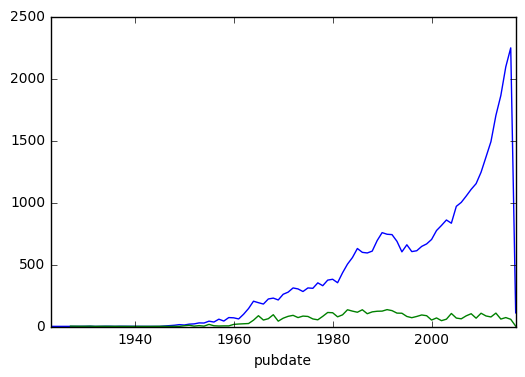

In [16]:
#terms = ['idiopathic pulmonary fibrosis', 'cryptogenic fibrosing alveolitis',
terms = ['usual interstitial pneumonia', 'asbestosis' ]

for term in terms:
    summaries, pubtypes, abstracts, keywords, rcrs = lit_search(term)
    df = make_result_dataframe( summaries, pubtypes, abstracts, keywords, rcrs )
    save_results_as_csv(term, df)
    explore_result_dataframe(df)
    


    
    


In [19]:
ipfjes_case_control_studies = ['23022860', '10968375', '24413348', '19782552', '17628464', '10841131', '8569361', 
'8087336', '15640309', '9571528', '18507288', '23022860', '2249047']

In [20]:
ipfjes_reviews = ['25621562', '24348069', '10193340', '11816818', '15331187', '16733403']

In [40]:
lit_search_for_pmids(ipfjes_case_control_studies)

Processed pmid 23022860
Processed pmid 10968375
Processed pmid 24413348
Processed pmid 19782552
Processed pmid 17628464
Processed pmid 10841131
Processed pmid 8569361
Processed pmid 8087336
Processed pmid 15640309
Processed pmid 9571528
Processed pmid 18507288
Processed pmid 23022860
Processed pmid 2249047


([{'2': {'articleids': [{'idtype': 'pubmed', 'idtypen': 1, 'value': '2'},
     {'idtype': 'pii', 'idtypen': 4, 'value': '0006-291X(75)90482-9'},
     {'idtype': 'rid', 'idtypen': 8, 'value': '2'},
     {'idtype': 'eid', 'idtypen': 8, 'value': '2'}],
    'attributes': [],
    'authors': [{'authtype': 'Author', 'clusterid': '', 'name': 'Bose KS'},
     {'authtype': 'Author', 'clusterid': '', 'name': 'Sarma RH'}],
    'availablefromurl': '',
    'bookname': '',
    'booktitle': '',
    'chapter': '',
    'doccontriblist': [],
    'docdate': '',
    'doctype': 'citation',
    'edition': '',
    'elocationid': '',
    'epubdate': '',
    'essn': '1090-2104',
    'fulljournalname': 'Biochemical and biophysical research communications',
    'history': [{'date': '1975/10/27 00:00', 'pubstatus': 'pubmed'},
     {'date': '1975/10/27 00:01', 'pubstatus': 'medline'},
     {'date': '1975/10/27 00:00', 'pubstatus': 'entrez'}],
    'issn': '0006-291X',
    'issue': '4',
    'lang': ['eng'],
    'last

'23022860,10968375,24413348,19782552,17628464,10841131,8569361,8087336,15640309,9571528,18507288,23022860,2249047'